In [1]:
import io
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
from itertools import permutations

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
from plot_triad import plot_one_triad_pretty_pro
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # has wide Unicode support

# Base directories
BASE_DIR = Path("/Users/wenlanzhang/PycharmProjects/Mapineq/src/")
DATA_DIR = Path("/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford")

# Load Data

## Meta Migration 

In [2]:
df = pd.read_csv(DATA_DIR/f"Migration/international_migration_flow.csv") 
df['year'] = pd.to_datetime(df['migration_month']).dt.year
df['month'] = pd.to_datetime(df['migration_month']).dt.month
df["migration_month"] = pd.to_datetime(df["migration_month"])

# Unique list from both columns
unique_countries = pd.unique(df[["country_from", "country_to"]].values.ravel())

df

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01-01,12,2019,1
1,AD,AE,2019-02-01,2,2019,2
2,AD,AE,2019-03-01,1,2019,3
3,AD,AE,2019-04-01,7,2019,4
4,AD,AE,2019-05-01,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138,2022,8
1563150,ZW,ZM,2022-09-01,162,2022,9
1563151,ZW,ZM,2022-10-01,149,2022,10
1563152,ZW,ZM,2022-11-01,104,2022,11


In [3]:
# Keep only what we need and rename to the model’s expected names
df_flow = (df
      .rename(columns={
          "country_from": "orig",
          "country_to": "dest",
          # "migration_month": "month",
          "num_migrants": "flow"
      })
      [["orig", "dest", "migration_month", "flow"]].copy()).rename(columns={
          "migration_month": "month"      })

# Make sure month is monthly datetime (month-start)
# df_flow["month"] = pd.to_datetime(df["month"]).dt.to_period("M").dt.to_timestamp()

# Clean types
df_flow["orig"] = df_flow["orig"].astype(str).str.upper()
df_flow["dest"] = df_flow["dest"].astype(str).str.upper()
df_flow["flow"] = pd.to_numeric(df_flow["flow"], errors="coerce").fillna(0).clip(lower=0).astype(int)

# If there are accidental duplicates (same orig-dest-month), aggregate
# df_flow = (df_flow.groupby(["orig", "dest", "month"], as_index=False)["flow"].sum())

df_flow

,orig,dest,month,flow
0,AD,AE,2019-01-01,12
1,AD,AE,2019-02-01,2
2,AD,AE,2019-03-01,1
3,AD,AE,2019-04-01,7
4,AD,AE,2019-05-01,0
...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138
1563150,ZW,ZM,2022-09-01,162
1563151,ZW,ZM,2022-10-01,149
1563152,ZW,ZM,2022-11-01,104


##  Meta SCI - VE missing
Source: https://data.humdata.org/dataset/social-connectedness-index

In [9]:
df_SCI = pd.read_csv(DATA_DIR/f"Migration/Excess/countries-countries-fb-social-connectedness-index-october-2021.tsv", sep="\t") 
# df_pop = df_pop[['Country Code', '2019', '2020', '2021', '2022']]
df_SCI

,user_loc,fr_loc,scaled_sci
0,AE,AE,1117179
1,AE,AG,5488
2,AE,AL,2101
3,AE,AM,3580
4,AE,AO,2326
...,...,...,...
34220,ZW,XK,262
34221,ZW,YT,1650
34222,ZW,ZA,366466
34223,ZW,ZM,196035


In [11]:
# Collect all unique country codes from SCI
sci_countries = set(df_SCI["user_loc"].unique()) | set(df_SCI["fr_loc"].unique())

# Collect all unique country codes from migration data
migration_countries = set(df["country_from"].unique()) | set(df["country_to"].unique())

# Countries in SCI but not in migration
missing_in_migration = sci_countries - migration_countries

# Countries in migration but not in SCI
missing_in_sci = migration_countries - sci_countries

print("Countries in SCI but missing in migration:")
print(sorted(missing_in_migration))

print("\nCountries in migration but missing in SCI:")
print(sorted(missing_in_sci))

Countries in SCI but missing in migration:
['AG', 'AW', 'CW', 'GF', 'GP', 'GU', 'IM', 'JE', 'KY', 'MQ', 'NC', 'PF', 'PR', 'RE', 'SC', 'YT']

Countries in migration but missing in SCI:
['AD', 'AF', 'ER', 'IL', 'IQ', 'RU', 'SD', 'SS', 'SY', 'TM', 'VE', 'YE']


## Country alpha2/3

In [4]:
df_country = pd.read_csv(DATA_DIR/f"all.csv") 
df_country = df_country[['name', 'alpha-2', 'alpha-3', 
                         'region', 'sub-region']]

df_country = df_country[df_country["alpha-2"].isin(unique_countries)]
df_country

,name,alpha-2,alpha-3,region,sub-region
0,Afghanistan,AF,AFG,Asia,Southern Asia
2,Albania,AL,ALB,Europe,Southern Europe
3,Algeria,DZ,DZA,Africa,Northern Africa
5,Andorra,AD,AND,Europe,Southern Europe
6,Angola,AO,AGO,Africa,Sub-Saharan Africa
...,...,...,...,...,...
240,"Venezuela, Bolivarian Republic of",VE,VEN,Americas,Latin America and the Caribbean
241,Viet Nam,VN,VNM,Asia,South-eastern Asia
246,Yemen,YE,YEM,Asia,Western Asia
247,Zambia,ZM,ZMB,Africa,Sub-Saharan Africa


## Population 
Source: World Bank  
https://data.worldbank.org/indicator/SP.POP.TOTL

In [5]:
df_pop = pd.read_csv(DATA_DIR/f"Migration/Excess/API_SP.POP.TOTL_DS2_en_csv_v2_710977.csv") 
df_pop = df_pop[['Country Code', '2019', '2020', '2021', '2022']]
df_pop

# source: https://data.worldbank.org/indicator/SP.POP.TOTL

,Country Code,2019,2020,2021,2022
0,ABW,109203.0,108587.0,107700.0,107310.0
1,AFE,675950189.0,694446100.0,713090928.0,731821393.0
2,AFG,37856121.0,39068979.0,40000412.0,40578842.0
3,AFW,463365429.0,474569351.0,485920997.0,497387180.0
4,AGO,32375632.0,33451132.0,34532429.0,35635029.0
...,...,...,...,...,...
261,XKX,1788891.0,1790151.0,1786079.0,1768096.0
262,YEM,35111408.0,36134863.0,37140230.0,38222876.0
263,ZAF,59587885.0,60562381.0,61502603.0,62378410.0
264,ZMB,18513839.0,19059395.0,19603607.0,20152938.0


In [6]:
# Make a mapping dictionary: alpha-3 → alpha-2
alpha_map = dict(zip(df_country["alpha-3"], df_country["alpha-2"]))

# Map alpha-3 to alpha-2
df_pop["Country Code"] = df_pop["Country Code"].map(alpha_map)

# Drop rows where mapping failed (NaN values in Country Code)
df_pop = df_pop.dropna(subset=["Country Code"]).reset_index(drop=True)

df_pop

,Country Code,2019,2020,2021,2022
0,AF,37856121.0,39068979.0,40000412.0,40578842.0
1,AO,32375632.0,33451132.0,34532429.0,35635029.0
2,AL,2854191.0,2837849.0,2811666.0,2777689.0
3,AD,76474.0,77380.0,78364.0,79705.0
4,AE,9445785.0,9401038.0,9575152.0,10074977.0
...,...,...,...,...,...
173,WS,209780.0,211944.0,213779.0,215261.0
174,YE,35111408.0,36134863.0,37140230.0,38222876.0
175,ZA,59587885.0,60562381.0,61502603.0,62378410.0
176,ZM,18513839.0,19059395.0,19603607.0,20152938.0


In [7]:
# Convert to long format
df_pop_long = df_pop.melt(id_vars=["Country Code"], 
                  var_name="Year", 
                  value_name="Population")

# After melting into long format (df_long)
df_pop_long = df_pop_long.rename(columns={
    "Country Code": "iso3",
    "Year": "year",
    "Population": "population"
})

df_pop_long

,iso3,year,population
0,AF,2019,37856121.0
1,AO,2019,32375632.0
2,AL,2019,2854191.0
3,AD,2019,76474.0
4,AE,2019,9445785.0
...,...,...,...
707,WS,2022,215261.0
708,YE,2022,38222876.0
709,ZA,2022,62378410.0
710,ZM,2022,20152938.0


## Prep

In [8]:
# Get unique country codes from both datasets
pop_codes = set(df_pop["Country Code"].unique())
flow_codes = set(df_flow["orig"].unique()) | set(df_flow["dest"].unique())

# Find differences
missing_in_pop = flow_codes - pop_codes
missing_in_flow = pop_codes - flow_codes

print("✅ Country codes in flow but missing in pop:")
print(missing_in_pop if missing_in_pop else "None")

print("\n✅ Country codes in pop but missing in flow:")
print(missing_in_flow if missing_in_flow else "None")

✅ Country codes in flow but missing in pop:
{'TW', 'NAN', 'XK'}

✅ Country codes in pop but missing in flow:
None


In [9]:
print("✅ Before cleaning:", len(df_flow))

# Allowed country codes (from df_pop)
valid_codes = set(df_pop["Country Code"].unique())

# Keep only rows where both orig and dest are in df_pop
df_flow = df_flow[
    df_flow["orig"].isin(valid_codes) & df_flow["dest"].isin(valid_codes)
].copy()

print("✅ After cleaning:", len(df_flow))

✅ Before cleaning: 1563154
✅ After cleaning: 1511698


# CT

In [10]:
import pandas as pd
# from cf_plus import CFPlus, CFPlusConfig
import pandas as pd
from cf_plus_safe import CFPlus, CFPlusConfig
from cf_plus_safe import diagnose_inputs

In [30]:
selected_countries = ["VE", "CL", "US", "EC", "CO"]  # 2-letter ISO codes

# 1️⃣ Filter population data
pops_filtered = df_pop_long[df_pop_long['iso3'].isin(selected_countries)].copy()

# 2️⃣ Filter flows data (both orig and dest must be in selected countries)
flows_filtered = df_flow[
    df_flow['orig'].isin(selected_countries) & df_flow['dest'].isin(selected_countries)
].copy()

# Optional: check
print("Filtered population data:")
pops_filtered.head()

print("\nFiltered flow data:")
flows_filtered.head()

Filtered population data:

Filtered flow data:


,orig,dest,month,flow
286748,CL,CO,2019-01-01,874
286749,CL,CO,2019-02-01,931
286750,CL,CO,2019-03-01,1187
286751,CL,CO,2019-04-01,966
286752,CL,CO,2019-05-01,902


In [31]:
flows = flows_filtered
pops = pops_filtered
pops

,iso3,year,population
30,CL,2019,19197744.0
35,CO,2019,49907985.0
46,EC,2019,17340021.0
167,US,2019,330226227.0
170,VE,2019,28938098.0
208,CL,2020,19370624.0
213,CO,2020,50629997.0
224,EC,2020,17546065.0
345,US,2020,331577720.0
348,VE,2020,28444077.0


In [17]:
report = diagnose_inputs(flows, pops, baseline_years=(2019,))

In [18]:
cfg = CFPlusConfig(
    train_end="2021-12-01",
    val_start="2021-07-01",
    alphas=(1e-6,1e-5,1e-4,1e-3,1e-2),
    baseline_years=(2019,),   # if your 2019 data are sparse, try (2019,2020,2021)
    use_external_covid=False,
    standardize_continuous=True
)

In [23]:
model = CFPlus(cfg).fit(flows, pops)   # <- no NaNs crash now
pred  = model.predict_mu(flows, pops)  # columns: orig, dest, month, flow, mu_hat, excess_pct
pred

,orig,dest,month,flow,mu_hat,excess_pct
0,CL,CO,2019-01-01,874.0,1368.267915,-0.361236
1,CL,CO,2019-02-01,931.0,1514.583189,-0.385309
2,CL,CO,2019-03-01,1187.0,1610.118250,-0.262787
3,CL,CO,2019-04-01,966.0,1684.498575,-0.426536
4,CL,CO,2019-05-01,902.0,1648.150516,-0.452720
...,...,...,...,...,...,...
955,VE,US,2022-08-01,6057.0,5002.799471,0.210722
956,VE,US,2022-09-01,8450.0,5350.470328,0.579300
957,VE,US,2022-10-01,10103.0,6178.210958,0.635263
958,VE,US,2022-11-01,8792.0,5392.301647,0.630473


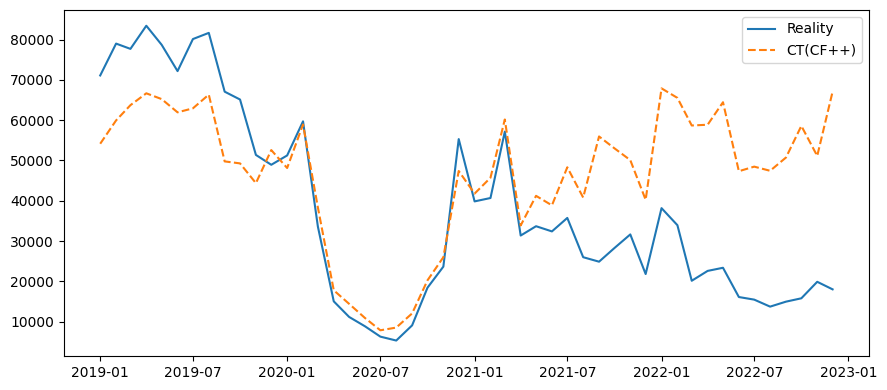

In [29]:
# （可选）可视化某条通道
import matplotlib.pyplot as plt
sub = pred[(pred.orig=="VE")&(pred.dest=="CO")].sort_values("month")
plt.figure(figsize=(9,4))
plt.plot(sub["month"], sub["flow"], label="Reality")
plt.plot(sub["month"], sub["mu_hat"], label="CT(CF++)", linestyle="--")
plt.legend(); plt.tight_layout(); plt.show()

In [22]:
pred

,orig,dest,month,flow,mu_hat,excess_pct
0,CL,CO,2019-01-01,874.0,1368.267915,-0.361236
1,CL,CO,2019-02-01,931.0,1514.583189,-0.385309
2,CL,CO,2019-03-01,1187.0,1610.118250,-0.262787
3,CL,CO,2019-04-01,966.0,1684.498575,-0.426536
4,CL,CO,2019-05-01,902.0,1648.150516,-0.452720
...,...,...,...,...,...,...
955,VE,US,2022-08-01,6057.0,5002.799471,0.210722
956,VE,US,2022-09-01,8450.0,5350.470328,0.579300
957,VE,US,2022-10-01,10103.0,6178.210958,0.635263
958,VE,US,2022-11-01,8792.0,5392.301647,0.630473


In [45]:
# flows = flows_filtered
# pops = pops_filtered

flows = df_flow
pops = df_pop_long

pops

,iso3,year,population
0,AF,2019,37856121.0
1,AO,2019,32375632.0
2,AL,2019,2854191.0
3,AD,2019,76474.0
4,AE,2019,9445785.0
...,...,...,...
707,WS,2022,215261.0
708,YE,2022,38222876.0
709,ZA,2022,62378410.0
710,ZM,2022,20152938.0


In [46]:
from cf_plus_tqdm import CFPlus, CFPlusConfig

cfg = CFPlusConfig(
    train_end="2021-12-01",
    val_start="2021-07-01",
    baseline_years=(2019, 2020, 2021),   # more robust if 2019 is sparse
    max_iter=20000,
    tol=1e-7,
    progress=True
)

In [47]:
model = CFPlus(cfg).fit(flows, pops)   # <- no NaNs crash now
pred  = model.predict_mu(flows, pops)  # columns: orig, dest, month, flow, mu_hat, excess_pct
pred

Alpha grid:   0%|          | 0/9 [00:00<?, ?it/s]

/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge after 12459 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(
/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge after 12407 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(
/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge after 12477 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS L

KeyboardInterrupt: 

In [34]:
# # 3) Sanity checks that avoid NaNs and bad splits

# from cf_plus_tqdm import compute_global_moy_baseline, compute_global_shock_index

# # Make sure baseline years exist (or adjust baseline_years)
# print(df_flow['month'].min(), df_flow['month'].max())
# print(df_pop_long[['iso3','year']].drop_duplicates().head())

# # Optional: visualize or inspect H_t to ensure it's finite
# H = compute_global_shock_index(df_flow[['orig','dest','month','flow']], baseline_years=(2019,2020,2021))
# assert np.isfinite(H.values).all()


2019-01-01 00:00:00 2022-12-01 00:00:00
  iso3  year
0   AF  2019
1   AO  2019
2   AL  2019
3   AD  2019
4   AE  2019


In [40]:
# # # 1) 读取Sample数据
flows = pd.read_csv("flows_sample.csv")     # orig, dest, month, flow
pops  = pd.read_csv("pops_sample.csv")      # iso3, year, population
pops

,iso3,year,population
0,ARG,2019,9000000.0
1,ARG,2020,9090000.0
2,ARG,2021,9180000.0
3,ARG,2022,9270000.0
4,CHL,2019,8000000.0
5,CHL,2020,8080000.0
6,CHL,2021,8160000.0
7,CHL,2022,8240000.0
8,COL,2019,19000000.0
9,COL,2020,19190000.0


In [41]:
# flows = df_flow
# pops = df_pop_long
df_flow

,orig,dest,month,flow
0,AD,AE,2019-01-01,12
1,AD,AE,2019-02-01,2
2,AD,AE,2019-03-01,1
3,AD,AE,2019-04-01,7
4,AD,AE,2019-05-01,0
...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138
1563150,ZW,ZM,2022-09-01,162
1563151,ZW,ZM,2022-10-01,149
1563152,ZW,ZM,2022-11-01,104


In [31]:
selected_countries = ["VE", "CL", "US", "EC", "CO"]  # 2-letter ISO codes

# 1️⃣ Filter population data
pops_filtered = pops[pops['iso3'].isin(selected_countries)].copy()

# 2️⃣ Filter flows data (both orig and dest must be in selected countries)
flows_filtered = flows[
    flows['orig'].isin(selected_countries) & flows['dest'].isin(selected_countries)
].copy()

# Optional: check
print("Filtered population data:")
pops_filtered.head()

print("\nFiltered flow data:")
flows_filtered.head()

flows = flows_filtered
pops = pops_filtered


Filtered population data:

Filtered flow data:


In [26]:
# # Check NaNs in population data
# print("NaNs in pops:")
# print(pops.isna().sum())

# # Check NaNs in flow data
# print("\nNaNs in flows:")
# print(flows.isna().sum())


# # Unique country codes
# pop_codes = set(pops['iso3'].unique())
# flow_codes = set(flows['orig'].unique()) | set(flows['dest'].unique())

# # Countries in flows but not in pops
# missing_in_pops = flow_codes - pop_codes
# print("\nCountries in flows but missing in pops:")
# print(missing_in_pops if missing_in_pops else "None")

# # Countries in pops but not in flows
# missing_in_flows = pop_codes - flow_codes
# print("\nCountries in pops but missing in flows:")
# print(missing_in_flows if missing_in_flows else "None")


NaNs in pops:
iso3          0
year          0
population    0
dtype: int64

NaNs in flows:
orig     0
dest     0
month    0
flow     0
dtype: int64

Countries in flows but missing in pops:
None

Countries in pops but missing in flows:
None


In [29]:
# 2) 配置：训练到 2021-12（挑 alpha），再对 2022 打分
cfg = CFPlusConfig(
    train_end="2021-12-01",
    val_start="2021-07-01",
    alphas=(1e-6,1e-5,1e-4,1e-3,1e-2),
    baseline_years=(2019,),          # 用 2019 做季节基准
    use_external_covid=False,        # 如果你有外部 COVID 指数，设 True 并传 covid_df
    standardize_continuous=True
)

In [35]:
# 3) 训练反事实
model = CFPlus(cfg).fit(flows, pops)
print("best alpha:", model.best_alpha_)

/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
PoissonRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [21]:
# 4) 预测反事实（全时段），并拿到当月“百分比超额”
pred = model.predict_mu(flows, pops)
# pred 有列：orig, dest, month, flow, mu_hat, excess_pct
pred

NaN counts per feature column:
log_pop_o    0
log_pop_d    0
H_t          0
covid_idx    0
dtype: int64

Rows with NaNs:
Empty DataFrame
Columns: [orig, dest, month, log_pop_o, log_pop_d, H_t, covid_idx]
Index: []


,orig,dest,month,flow,mu_hat,excess_pct
0,VEN,CHL,2019-01-01,2261.0,2315.566337,-0.023565
1,VEN,CHL,2019-02-01,2347.0,2040.986377,0.149934
2,VEN,CHL,2019-03-01,2263.0,2227.067725,0.016134
3,VEN,CHL,2019-04-01,1977.0,2123.850133,-0.069143
4,VEN,CHL,2019-05-01,2369.0,2295.062537,0.032216
...,...,...,...,...,...,...
523,TUR,DEU,2022-08-01,297.0,309.962126,-0.041818
524,TUR,DEU,2022-09-01,335.0,319.042675,0.050016
525,TUR,DEU,2022-10-01,312.0,326.161560,-0.043419
526,TUR,DEU,2022-11-01,338.0,338.362508,-0.001071


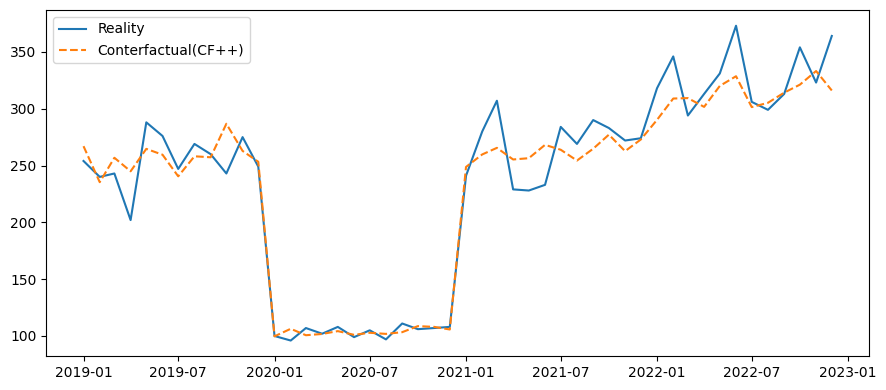

In [9]:
# （可选）可视化某条通道
import matplotlib.pyplot as plt
sub = pred[(pred.orig=="CHL")&(pred.dest=="USA")].sort_values("month")
plt.figure(figsize=(9,4))
plt.plot(sub["month"], sub["flow"], label="Reality")
plt.plot(sub["month"], sub["mu_hat"], label="Conterfactual(CF++)", linestyle="--")
plt.legend(); plt.tight_layout(); plt.show()
